In [1]:
import pandas as pd

df = pd.read_csv("HR-Employee-Attrition.csv")  # exact file path in Colab
df.head()


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [2]:
drop_cols = ['EmployeeCount', 'Over18', 'StandardHours', 'EmployeeNumber']
df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')
df.head()


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,...,3,1,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,...,4,4,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,...,3,2,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,Female,...,3,3,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,Male,...,3,4,1,6,3,3,2,2,2,2


In [3]:
df['Attrition_Flag'] = df['Attrition'].apply(lambda x: 1 if x == "Yes" else 0)

X = df.drop(columns=['Attrition', 'Attrition_Flag'])
y = df['Attrition_Flag']


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

num_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

numeric_transformer = Pipeline(steps=[("scaler", StandardScaler())])
categorical_transformer = Pipeline(steps=[("onehot", OneHotEncoder(handle_unknown="ignore"))])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ])

model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("classifier", LogisticRegression(max_iter=1000))
])

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nReport:\n", classification_report(y_test, y_pred))


Accuracy: 0.8605442176870748

Confusion Matrix:
 [[237  10]
 [ 31  16]]

Report:
               precision    recall  f1-score   support

           0       0.88      0.96      0.92       247
           1       0.62      0.34      0.44        47

    accuracy                           0.86       294
   macro avg       0.75      0.65      0.68       294
weighted avg       0.84      0.86      0.84       294



In [5]:
df_bi = df.copy()
df_bi["Attrition_Prob"] = model.predict_proba(X)[:, 1]
df_bi["Attrition_Pred"] = model.predict(X)

df_bi.to_csv("Attrition_Predictions_PowerBI.csv", index=False)
print("Exported → Attrition_Predictions_PowerBI.csv")


Exported → Attrition_Predictions_PowerBI.csv


Saved → SHAP_Attrition_Features.png


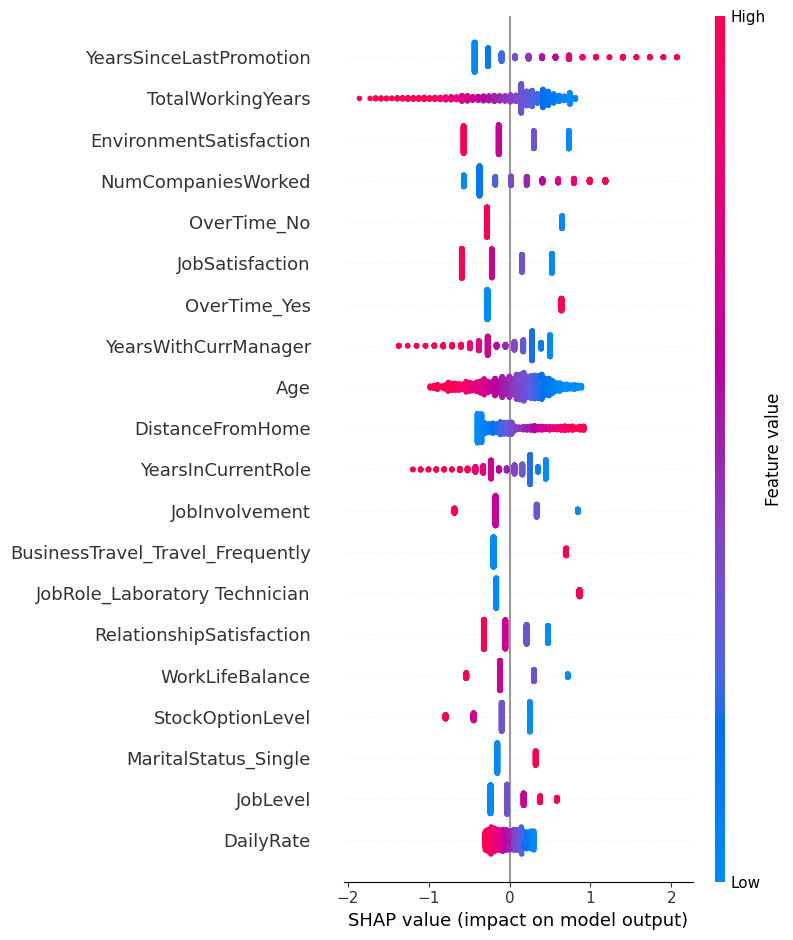

In [6]:
!pip install shap
import shap
import matplotlib.pyplot as plt

preprocess_model = model.named_steps["preprocess"]
X_train_proc = preprocess_model.transform(X_train)

ohe = preprocess_model.named_transformers_["cat"].named_steps["onehot"]
ohe_cols = ohe.get_feature_names_out(cat_cols)
feature_names = list(num_cols) + list(ohe_cols)

explainer = shap.LinearExplainer(model.named_steps["classifier"], X_train_proc)
shap_values = explainer.shap_values(X_train_proc)

shap.summary_plot(shap_values, X_train_proc, feature_names=feature_names, show=False)
plt.savefig("SHAP_Attrition_Features.png", dpi=300)
print("Saved → SHAP_Attrition_Features.png")


****

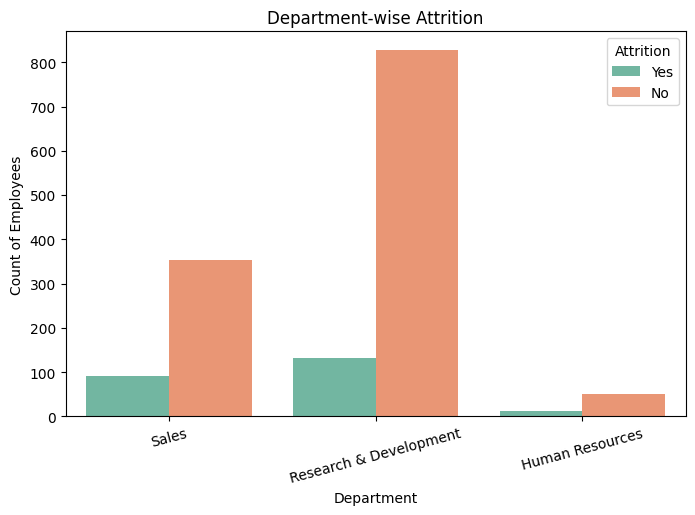

In [7]:
import seaborn as sns

plt.figure(figsize=(8,5))
sns.countplot(data=df, x="Department", hue="Attrition", palette="Set2")
plt.title("Department-wise Attrition")
plt.xlabel("Department")
plt.ylabel("Count of Employees")
plt.xticks(rotation=15)
plt.show()


In [8]:
df['SalaryBand'] = pd.cut(df['MonthlyIncome'],
                          bins=[0, 3000, 6000, 9000, 12000, 20000],
                          labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])


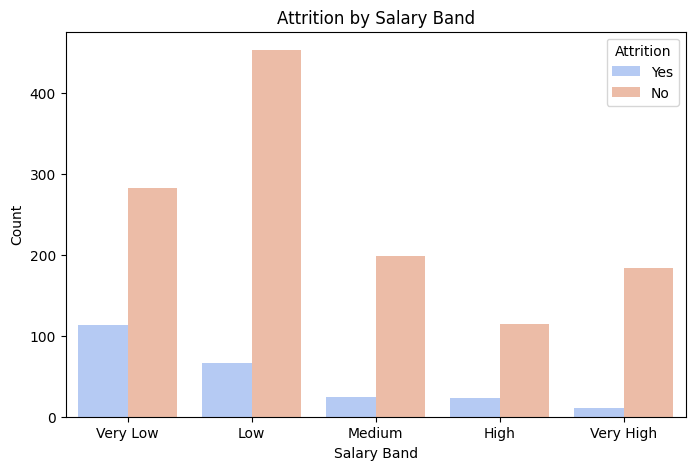

In [9]:
plt.figure(figsize=(8,5))
sns.countplot(data=df, x="SalaryBand", hue="Attrition", palette="coolwarm")
plt.title("Attrition by Salary Band")
plt.xlabel("Salary Band")
plt.ylabel("Count")
plt.show()


/tmp/ipython-input-2246886220.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Attrition", y="YearsSinceLastPromotion", palette="magma")


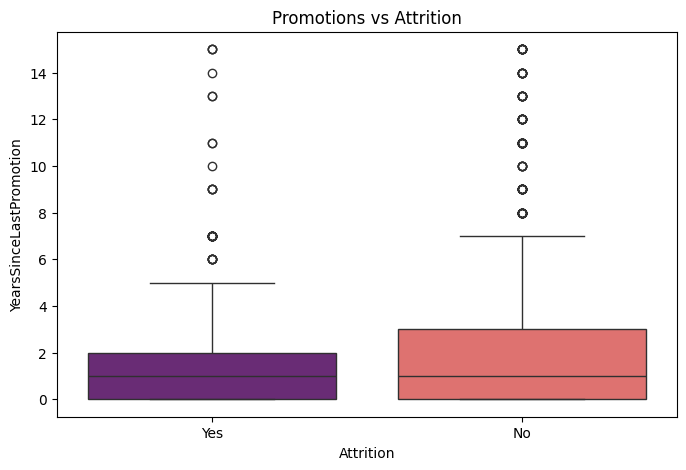

In [10]:
plt.figure(figsize=(8,5))
sns.boxplot(data=df, x="Attrition", y="YearsSinceLastPromotion", palette="magma")
plt.title("Promotions vs Attrition")
plt.show()
